# Board Game Score Prediction Project
In this notebook we will attemp to predict a new game's score based on it's characteristic.
To avoid data leakage, the prediction will not use any feature that is based on the reviews given, since for brand new games, such reviews don't exist yet.

The projects process contains:

Import and cleaning of the data
EDA (exploratory data analysis)
Model creation and evaluation

## Project set up

### Dataset Explanation
Metadata table
The metadata table we are going to use is the games info table, which has the following columns:

id - the game id (across all datasets)

primary - game name

General information columns:

yearpublished, playingtime averageweight - how complex is the game (1-5) min/max players - what is the min/max players this game is suited to

Tag columns:

boardgamemechanic, boardgamedesigner, boardgamepublisher, boardgamecategory

Ranking related columns

Average - average users' rating score

### Imports

In [1]:
import numpy as np 
import shap
import pandas as pd 
import os
import re
from basic_utils import INPUT_FOLDER, dfCleaner
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import RFE

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

### Constants

In [2]:
DATA_PATH = os.path.join(INPUT_FOLDER, "boardgamegeek-reviews")
GAME_INFO_COLS = ['id','primary','yearpublished','minplayers','maxplayers',
                  'playingtime','boardgamecategory','boardgamemechanic'
                  ,'boardgamedesigner','boardgamepublisher', 'average']
df_cleaner = dfCleaner()
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
FEATURE_RATIO = np.arange(start=0.2, stop=1, step=0.05)
MAX_PLAYERS = 100
MAX_PLAYINGTIME = 1200
RANDOM_STATE = 4321
TOP_MECHANICS = 75
TOP_CATEGORIES = 75

### Functions

In [3]:
def clean_list_columns(df_to_clean, column_name):
    new_df = df_to_clean.copy()
    new_df[column_name] = new_df[column_name].str.split(",").apply(lambda x: x[0])
    new_df[column_name] = new_df[column_name].str.replace("[","").str.replace("]","")
    return new_df

In [4]:
def extract_values_from_list_columns(df_to_extract, column_name):
    tags_column = feature_enginnering[column_name].tolist()
    clean_values = []
    for tag_list in tags_column:
        clean_list = [tag.strip().lower().replace("[","").replace("]","").replace("'","").replace(" ","_").replace(",","_") for tag in tag_list.split("',")]
        clean_values.append(','.join(clean_list))
    all_tags = ','.join(clean_values).split(",")
    return clean_values

In [5]:
def filter_tags_by_top_tags(tags_list, top_tags, col_type):
    tags_filtered = []
    for tags_str in tags_list:
        for tag in tags_str.split(','):
            if tag not in top_tags:
                tags_str = tags_str.replace(tag, f'other_{col_type}')
        tags_filtered.append(list(set(tags_str.split(','))))
    return tags_filtered

## Data Cleaning
This step is focused on identifying and dealing with missing/abnormal values in the data

In [6]:
games_info = pd.read_csv(os.path.join(DATA_PATH, "games_detailed_info.csv"), 
                         usecols=GAME_INFO_COLS)
games_info.sample(5)

,id,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamedesigner,boardgamepublisher,average
2390,23540,Shikoku 1889,2004,2,6,210,"['Economic', 'Trains', 'Transportation']","['Auction/Bidding', 'Market', 'Network and Rou...",['Yasutaka Ikeda'],"['Deep Thought Games, LLC', 'Grand Trunk Games...",7.98617
7451,7483,Schatz der Drachen,2003,2,5,20,"['Card Game', ""Children's Game"", 'Memory']","['Memory', 'Set Collection']",['Reiner Knizia'],"['FoxMind', '(Unknown)', 'Bloom Games (Korean)...",6.67329
21386,265120,Copernico,2018,1,5,25,"['Card Game', 'Deduction', 'Puzzle']","['Card Drafting', 'Pattern Building', 'Simulta...","['Julio Romacho', 'David S Serrano']",['Tetrakis'],7.41667
9183,102219,Connect 4 Launchers,2010,2,2,15,"['Action / Dexterity', ""Children's Game"", 'Puz...",NaN,['Craig Van Ness'],['Hasbro'],6.29703
6826,1958,The Game of Nations,1973,2,4,120,"['Economic', 'Political', 'Spies/Secret Agents']","['Action Points', 'Area Movement', 'Events', '...",['Miles Copeland'],"['Gibsons', 'Grow Jogos e Brinquedos', 'Parker...",5.23162


this dataset contains information about 20K games
we can see that some columns have outlier results such as playing time of 1000 hours, 0 min players, or 999 max players.

In [7]:
games_info.describe()

,id,yearpublished,minplayers,maxplayers,playingtime,average
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,118133.093847,1986.094910,2.007027,5.709491,90.509177,6.417127
std,105310.419253,210.042496,0.688957,15.102385,534.826511,0.929178
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,1.041330
25%,12280.500000,2001.000000,2.000000,4.000000,25.000000,5.832710
50%,105187.000000,2011.000000,2.000000,4.000000,45.000000,6.446360
75%,207013.000000,2017.000000,2.000000,6.000000,90.000000,7.039515
max,350992.000000,2023.000000,10.000000,999.000000,60000.000000,9.568290


we can see that we have some games with missing categories, mechanic, designers


In [8]:
games_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21631 entries, 0 to 21630
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21631 non-null  int64  
 1   primary             21631 non-null  object 
 2   yearpublished       21631 non-null  int64  
 3   minplayers          21631 non-null  int64  
 4   maxplayers          21631 non-null  int64  
 5   playingtime         21631 non-null  int64  
 6   boardgamecategory   21348 non-null  object 
 7   boardgamemechanic   20041 non-null  object 
 8   boardgamedesigner   21035 non-null  object 
 9   boardgamepublisher  21630 non-null  object 
 10  average             21631 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


We remove rows with missing data (since this is a small amount of rows)

In [9]:
games_info_full = games_info.dropna()
games_info_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19336 entries, 0 to 21630
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  19336 non-null  int64  
 1   primary             19336 non-null  object 
 2   yearpublished       19336 non-null  int64  
 3   minplayers          19336 non-null  int64  
 4   maxplayers          19336 non-null  int64  
 5   playingtime         19336 non-null  int64  
 6   boardgamecategory   19336 non-null  object 
 7   boardgamemechanic   19336 non-null  object 
 8   boardgamedesigner   19336 non-null  object 
 9   boardgamepublisher  19336 non-null  object 
 10  average             19336 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 1.8+ MB


there are ~24 games with missing player count

In [10]:
len(games_info_full[games_info_full['minplayers']==0])

24

similarly, there are 24 games with max players of 100 and above, 
which is usually a placeholder for unknown number of players

In [11]:
len(games_info_full[games_info_full['maxplayers']>=MAX_PLAYERS])

24

there are ~120 games with playing time larger than 20 hours

In [12]:
len(games_info_full[games_info_full['playingtime']>=MAX_PLAYINGTIME])

116

Next, we replace all the columns with illogical values such as 0 playing time, min players = 0, etc...

In [13]:
# we assume that most likely the minimum number of players is 2 (although solo games do exist)
games_info_full.loc[games_info_full['minplayers'] == 0, 'minplayers'] = 2
# we replace those games with the median size for max players which is 4
games_info_full.loc[games_info_full['maxplayers'] >= MAX_PLAYERS, 'maxplayers'] = int(np.median(games_info_full['maxplayers']))
# we replace games with too high playing time with the median value which is 45 minutes
games_info_full.loc[(games_info_full['playingtime'] >= MAX_PLAYINGTIME) | (games_info_full['playingtime'] ==0), 'playingtime'] = int(np.median(games_info_full['playingtime']))

## Feature engineering
In this section we focus of extracting features from our data, which is mainly focused on converting the tag columns (designer/pubshlier/mechanic/category) into features.

In [14]:
# this function takes a list within a cell and extracts the first value
# we do this because we assume that the first publisher/designer in the list
# is the main one.
games_single_creator = clean_list_columns(games_info_full, 'boardgamedesigner')
games_single_creator = clean_list_columns(games_single_creator, 'boardgamepublisher')

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [15]:
# in our sample of 19k games, we have ~6700 designers
games_single_creator['boardgamedesigner'].nunique()

6757

In [16]:
# in our sample of 19k games, we have ~3500 designers
games_single_creator['boardgamepublisher'].nunique()

3538

Since our publisher and designer column have too many possible values, it will be better to count publisher/designer frequency rather than creating a dummy variable for each one. 

In [17]:
feature_enginnering = games_single_creator.copy()
# now we can better see the distribution
feature_enginnering['publisher_freq'] = feature_enginnering.groupby('boardgamepublisher')['boardgamepublisher'].transform('count')
# then we run the same process for designer
feature_enginnering['designer_freq'] = feature_enginnering.groupby('boardgamedesigner')['boardgamedesigner'].transform('count')

we clean out cases where the game was self published/designed, so the true
freqency should be 1 and not the frequency of that name (not all games that were "self published" were published by the same publisher)

In [18]:
feature_enginnering.loc[feature_enginnering['boardgamepublisher'].str.contains('Self-Published'),'publisher_freq'] = 1
feature_enginnering.loc[feature_enginnering['boardgamepublisher'].str.contains('Web published'),'publisher_freq'] = 1
feature_enginnering.loc[feature_enginnering['boardgamedesigner'].str.contains('Uncredited'),'designer_freq'] = 1

For mechanics and categories, our method will be slightly different. First of all, mechanics and categories are not exclusive, a game usually has more than 1 mechnic. Second, mechanics are not orderly, meaning that the first mechanic on the list is not necessarily the main mechanic of the game.

Therefore, we will create dummy variables for each mechanic/category, after converting unpopular mechanics into "other", to avoid creating too many variables.

In [19]:
clean_mechanics_col = extract_values_from_list_columns(df_to_extract=feature_enginnering,
                                                column_name='boardgamemechanic')
# we have 190 unique mechanics
all_mechanics = ','.join(clean_mechanics_col).split(',')
len(set(all_mechanics))

190

we can see that the mechanics distribution has a large tail to the right,
meaning that some mechanics are highly popular, while the rest are very uncommon.

In [20]:
mechanics_occurence = pd.DataFrame.from_dict(Counter(all_mechanics), orient='index', columns=['freq'])
mechanics_occurence.describe()

,freq
count,190.000000
mean,321.957895
std,709.057276
min,1.000000
25%,21.250000
50%,47.000000
75%,273.000000
max,5925.000000


for ease of analysis, we would keep only the top 25% mechanics, and mark the rest as "other".
this gives us the top 48 mechanics

In [21]:
top_mechanics = mechanics_occurence[mechanics_occurence['freq'] > np.percentile(mechanics_occurence['freq'], TOP_MECHANICS)]
top_mechanics = top_mechanics.reset_index()['index'].tolist()
len(top_mechanics)

48

In [22]:
# replace non top mechanics with "other"
mechanics_filtered = filter_tags_by_top_tags(tags_list=clean_mechanics_col,
                                            top_tags=top_mechanics,
                                            col_type='mechanic')
# we add back the clean and filtered mechanics to the df
feature_enginnering['mechanics'] = mechanics_filtered
# and turn those columns into dummy columns
top_mechanics.append("other_mechanic")
for mechanic in top_mechanics:
    feature_enginnering[mechanic] = feature_enginnering['mechanics'].apply(lambda x: mechanic in x)

# we can see here that most games have only 1 top mechanic (most likely - "other")
# and the most has 11 mechanics
feature_enginnering['any_mechanic'] = feature_enginnering[top_mechanics].sum(axis=1)
feature_enginnering['any_mechanic'].describe()

count    19336.000000
mean         3.037495
std          1.914514
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         17.000000
Name: any_mechanic, dtype: float64

we repeat the process for "boardgamecategory"

In [23]:
clean_category_col = extract_values_from_list_columns(df_to_extract=feature_enginnering,
                                                column_name='boardgamecategory')
# we have 135 unique categories
all_categories = ','.join(clean_category_col).split(',')
len(set(all_categories))

135

In [24]:
# we can see that the categories are more even distributed, although with a high standard diviation
categories_occurence = pd.DataFrame.from_dict(Counter(all_categories), orient='index', columns=['freq'])
categories_occurence.describe()

,freq
count,135.000000
mean,377.614815
std,700.812428
min,1.000000
25%,13.500000
50%,155.000000
75%,395.000000
max,5734.000000


In [25]:
# for ease of analysis, we would keep only the top 25% categories, and mark the rest as "other"
# this gives us the top 34 mechanics
top_categories = categories_occurence[categories_occurence['freq'] > np.percentile(categories_occurence['freq'], TOP_CATEGORIES)]
top_categories = top_categories.reset_index()['index'].tolist()
len(top_categories)

34

In [26]:
# replace non top categories with "other"
categories_filtered = filter_tags_by_top_tags(tags_list=clean_category_col,
                                            top_tags=top_categories,
                                             col_type='category')
# we add back the clean and filtered mechanics to the df
feature_enginnering['categories'] = categories_filtered
# and turn those columns into dummy columns
top_categories.append("other_category")
for category in top_categories:
    feature_enginnering[category] = feature_enginnering['categories'].apply(lambda x: category in x)

# we can see here that most games have about 2 mechanics
# and the most has 7 mechanics
feature_enginnering['any_category'] = feature_enginnering[top_categories].sum(axis=1)
feature_enginnering['any_category'].describe()

count    19336.000000
mean         2.514532
std          1.252335
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: any_category, dtype: float64

## EDA
Now that all of our features are ready, we can take a deeper look at the data

we can see that most games are scored between 6-7, and the overall distribution
matches a normal distribution

[Text(0.5, 0, 'Game Rating'),
 Text(0, 0.5, 'Percent of games (%)'),
 Text(0.5, 1.0, 'Ratings distribution')]

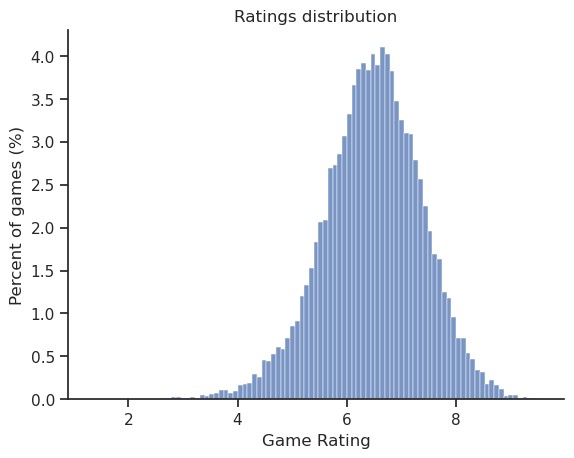

In [27]:
chart = sns.histplot(data=feature_enginnering, x='average', stat='percent')
chart.set(xlabel="Game Rating",
       ylabel='Percent of games (%)',
       title='Ratings distribution')

Looking at playing time, games are usually up to 3 hours, while most are around 50 minutes

[Text(0.5, 0, 'Length of play (minutes)'),
 Text(0.5, 1.0, 'Playtime length distribution')]

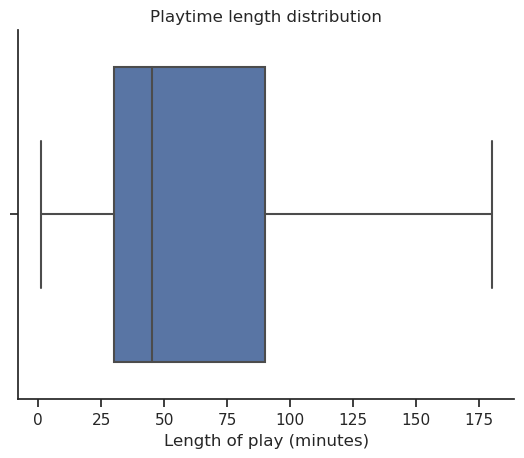

In [28]:
chart = sns.boxplot(data=feature_enginnering, x='playingtime', showfliers=False)
chart.set(xlabel="Length of play (minutes)",
       title='Playtime length distribution')

Publish year - while our data includes very old games 
that were excludes from the chart for ease of visability like chess and go
we can see that the resurfce of board games has started around the year 2000
and we get more and more games each year

[Text(0.5, 0, 'Publish Year'), Text(0.5, 1.0, 'Publish Year Distribution')]

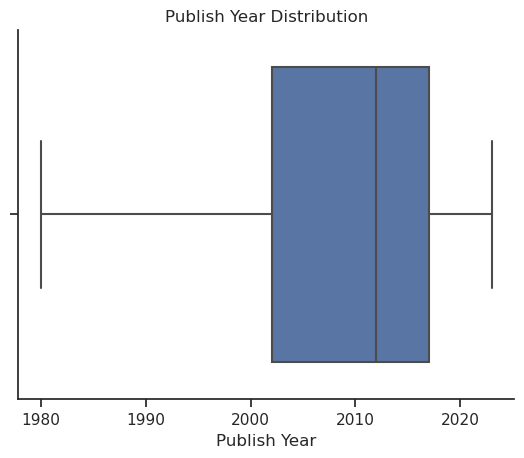

In [29]:
chart = sns.boxplot(data=feature_enginnering, x='yearpublished', showfliers=False)
chart.set(xlabel="Publish Year",
       title='Publish Year Distribution')

we can see that games that tend to be belong to multiple categories
also tend to have a slightly higher rating

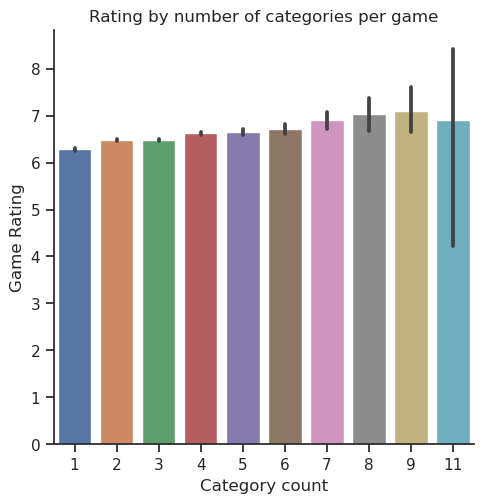

In [30]:
chart = sns.catplot(data=feature_enginnering, kind="bar", x="any_category", y="average")
chart.set(xlabel="Category count",
          ylabel="Game Rating",
          title='Rating by number of categories per game')

for mechanics, the more the marrier is not always true, 
and perhaps there is such thing as too much, since score rises
with mechanics up to a point.

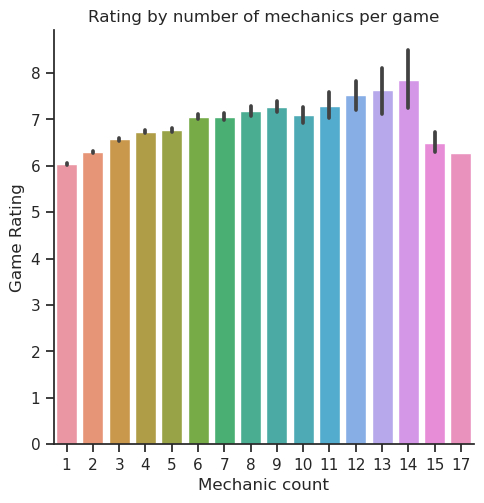

In [31]:
chart = sns.catplot(data=feature_enginnering, kind="bar", x="any_mechanic", y="average")
chart.set(xlabel="Mechanic count",
          ylabel="Game Rating",
          title='Rating by number of mechanics per game')

There is no obvious connection between playing time and score, although we can see that the really long games (>5 hours) tend to have in general better ratings

[Text(0.5, 0, 'Length of play (minutes)'),
 Text(0, 0.5, 'Game Rating'),
 Text(0.5, 1.0, 'Rating by game length')]

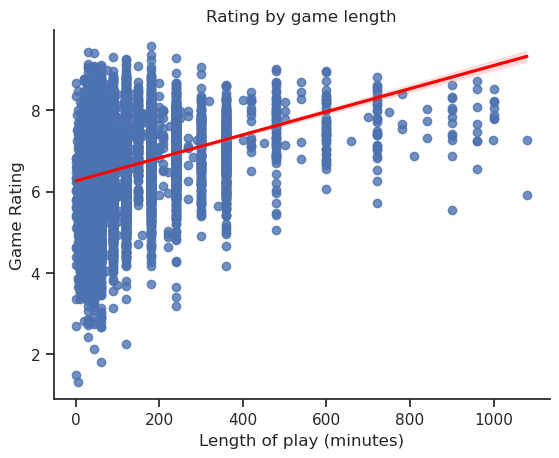

In [32]:
chart = sns.regplot(data=feature_enginnering, x='playingtime', y='average',
                   line_kws={'color':'red'})
chart.set(xlabel="Length of play (minutes)",
          ylabel="Game Rating",
          title='Rating by game length')

similar to play length, when looking at designers we see that the worst games are centered around the lower values (unknown designers), and while the top designers don't have a garunteed win, they at least have a "reasonable" rating.
here we can see why Reiner Knizia is one of the popular designers, 
having designed almost 300 games.

[Text(0.5, 0, '# of games designed'),
 Text(0, 0.5, 'Game Rating'),
 Text(0.5, 1.0, 'Rating by Designer')]

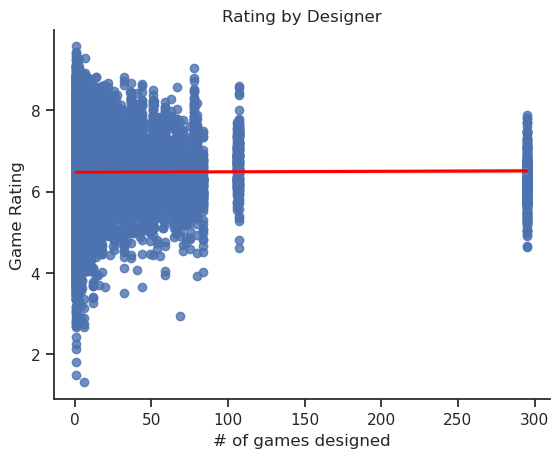

In [33]:
chart = sns.regplot(data=feature_enginnering, x='designer_freq', y='average',
           line_kws={'color':'red'})
chart.set(xlabel="# of games designed",
          ylabel="Game Rating",
          title='Rating by Designer')

interestinly, we can see here that being a big publisher doesn't mean you only
have good games in your arsenal. It is perhaps the small publishers that
tend to have more successful games, or perhaps more innovative ones, taking larger risks.

[Text(0.5, 0, '# of games published'),
 Text(0, 0.5, 'Game Rating'),
 Text(0.5, 1.0, 'Rating by Publisher')]

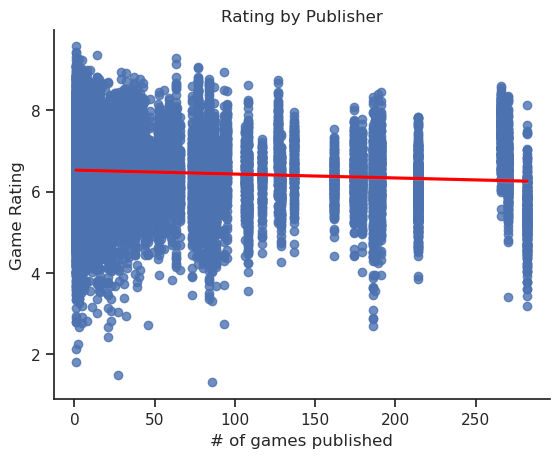

In [34]:
chart = sns.regplot(data=feature_enginnering, x='publisher_freq', y='average',
           line_kws={'color':'red'})
chart.set(xlabel="# of games published",
          ylabel="Game Rating",
          title='Rating by Publisher')

we can see that the most popular mechanics out of the top mechanics chosen
are dice rolling (games like Settlers of Catan), and hand manegement (games like Taki or Uno)

[Text(0.5, 0, '# of games'),
 Text(0, 0.5, 'Mechanic'),
 Text(0.5, 1.0, 'Mechanic popularity')]

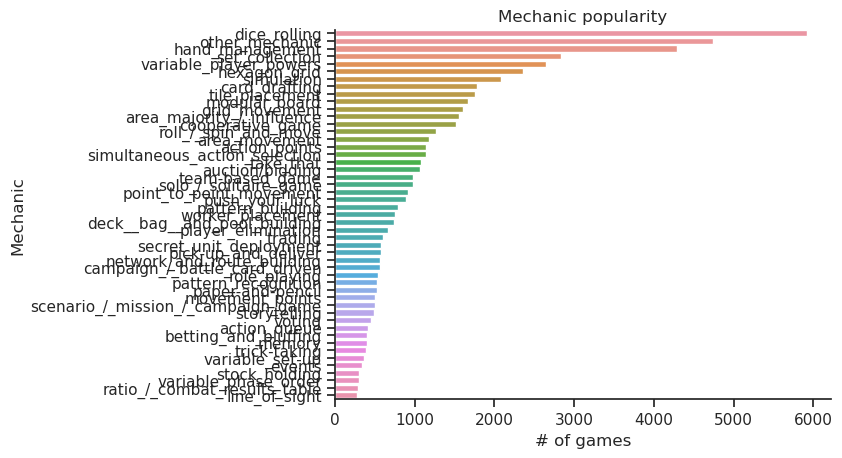

In [35]:
top_mechanics_count = feature_enginnering[top_mechanics].sum().to_frame().reset_index().rename(columns={0: "count"}).sort_values(by='count', ascending=False)
top_mechanics_count = top_mechanics_count[top_mechanics_count['index']!="other"]
chart = sns.barplot(data=top_mechanics_count, y='index', x='count')
chart.set(xlabel="# of games",
          ylabel="Mechanic",
          title='Mechanic popularity')

we can see that the most popular categories out of the top categories chosen
are card games (games like Taki or Uno), and wargames (games like Risk)

[Text(0.5, 0, '# of games'),
 Text(0, 0.5, 'Category'),
 Text(0.5, 1.0, 'Category popularity')]

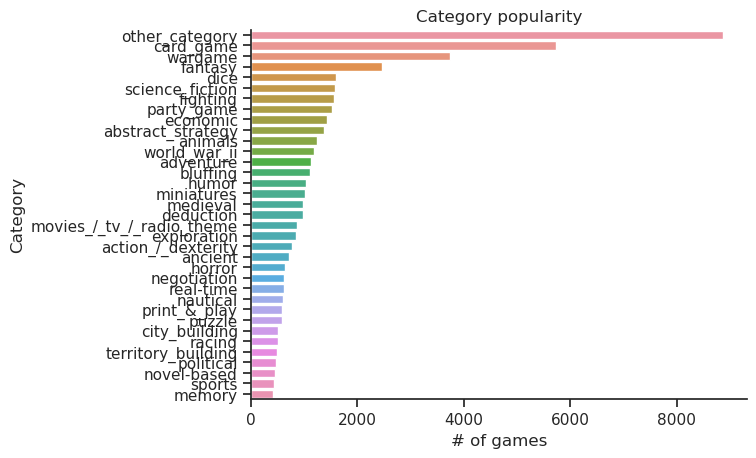

In [36]:
top_category_count = feature_enginnering[top_categories].sum().to_frame().reset_index().rename(columns={0: "count"}).sort_values(by='count', ascending=False)
top_category_count = top_category_count[top_category_count['index']!="other"]
chart = sns.barplot(data=top_category_count, y='index', x='count')
chart.set(xlabel="# of games",
          ylabel="Category",
          title='Category popularity')

## Prediction model

In this section we use linear regression and random forest to attempt to predict a game's score based on the features from the previous section.
it is worth noting that other models such as svm and polynomial regression were also tested but due to poor results and long training time they were ommited.
Lastly, we show which features were significant and what is their level of contribution to the prediction.

In [37]:
features = ['yearpublished', 'minplayers', 'maxplayers', 'playingtime',
           'publisher_freq', 'designer_freq', 'any_category', 'any_mechanic'] + top_mechanics + top_categories
label = ['average']

For the linear regression, we are using RepeatedKFold to randomally divide our dataset into different 10 test-train splits so that we would have a more reliable accuracy result that is not based on a "lucky" split.
this process is repeated several times. by taking the average of these different splits, we can be relativly sure of our result.

In [38]:
x = feature_enginnering[features].to_numpy()
# turn boolean values into 1-0
x = np.multiply(x, 1).astype(int)
y = feature_enginnering[label].to_numpy()
y = np.ravel(y,order='C')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

a basic linear regression provides predictions with an avg error of 9.3%

In [39]:
linear_results = cross_validate(LinearRegression(), x, y, cv=cv,
                           scoring='neg_mean_absolute_percentage_error')
np.mean(linear_results['test_score'])

-0.0930321657986756

a random forest model gives us predictions of 7.8% accuracy

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.3, 
    random_state=RANDOM_STATE)

rfr_estimator = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_estimator.fit(X_train, y_train)
y_pred = rfr_estimator.predict(X_test)
metrics.mean_absolute_percentage_error(y_test, y_pred)

0.07860302375887952

Here, we filter our features based on their level of signifigance to keep only those that help the accuracy of our model. To find the optimal amount of features, we run the regression with several configurations and measure the accuracy of each one.

In [41]:
n_features_comparison = []
for n_features in FEATURE_RATIO:
    selector = RFE(LinearRegression(), n_features_to_select=n_features)
    selector = selector.fit(x, y)
    new_features = selector.get_feature_names_out(features)
    linear_results = cross_validate(LinearRegression(), feature_enginnering[new_features], y, cv=cv,
                               scoring='neg_mean_absolute_percentage_error')
    n_features_comparison.append({"n_features": n_features, "score": np.mean(linear_results['test_score']),
                           "feature_names": new_features})
n_features_df = pd.DataFrame(n_features_comparison)

we can see that our accuracy starts to fall drastically after we use less than 45% of the features.
meaning that the vast majority of our features don't contribue to the model's explanability. therefore, we will remove those and keep only the relevant 45%.

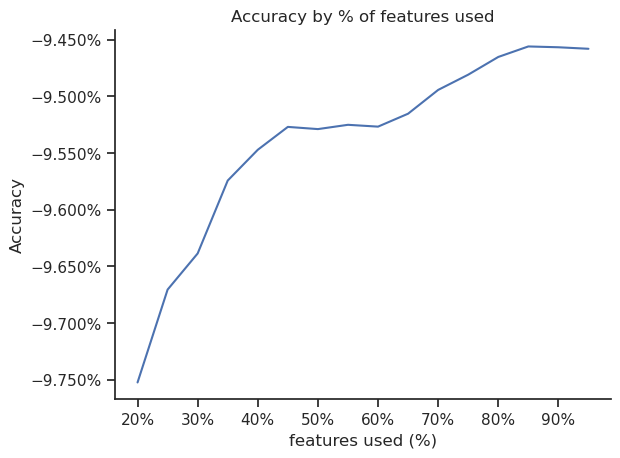

In [42]:
chart = sns.lineplot(n_features_df, y='score', x='n_features')
chart.set(xlabel="features used (%)",
          ylabel="Accuracy",
          title='Accuracy by % of features used')
chart.xaxis.set_major_formatter(mtick.PercentFormatter(1))
chart.yaxis.set_major_formatter(mtick.PercentFormatter(1))

Here, we use shapley values to measure the contribution of each feature to a game's score. Features on top are the most influential ones.
From this analysis we can see that our top influencing factors are the categories: war games, roll and move games, and cooperative games. Additionally,  the "variable player powers" mechanic is considered influential.

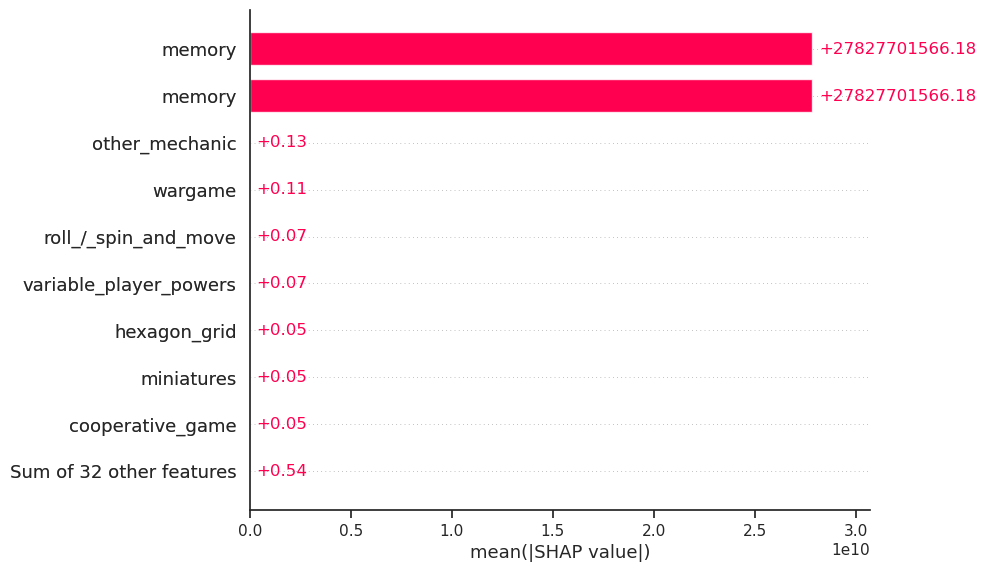

In [43]:
features_to_use = n_features_df.at[5, "feature_names"]
reg_model = LinearRegression().fit(feature_enginnering[features_to_use], feature_enginnering[label])
explainer = shap.Explainer(reg_model, feature_enginnering[features_to_use])
shap_values = explainer(feature_enginnering[features_to_use])
shap.plots.bar(shap_values)